Импортируем библиотеки

In [37]:
import datetime                  
import pickle                    
import requests                  
import pandas as pd              
import numpy as np               
import time            
from tqdm import tqdm_notebook 

Указываем версию апи и считываем токен из файла

In [38]:
version = '5.103'
with open('token.txt') as f:
    token = f.read()

<h1>Определяем функции</h1>

In [79]:
def getGroupMembers(group_id):
    """
        Возвращает список всех пользователей данной группы
        Итерации идут батчами по 1000 пользователей
        
        group_id: string
            идентификатор группы (ссылка)
    """
    
    # Узнаём число запросов, которое надо сделать 
    count = vkDownload('groups.getMembers','group_id=' + group_id)['response']['count']
    
    # выясняем, сколько запросов нам понадобиться
    n = int(np.ceil(count/1000))  
    
    # вектор, где мы будем хранить id пользователей
    members = []     
    
    for i in tqdm_notebook(range(n)): 
        # при помощи метода groups.getMembers получаем пользователей группы
        current_members = vkDownload('groups.getMembers','group_id='+group_id+'&offset='+str(1000*i))
        members.extend(current_members['response']['items'])
        
        # перед следующим запросом немножко подождем
        time.sleep(0.4)
        
    return members

In [40]:
def vkDownload(method, parameters, token=token, version=version):
    """
        Возвращает результат запроса по методу
        
        method: string
            метод из документации, который хотим использовать
            
        parameters: string
            параметры используемого метода
            
        token: string
            токен Oauth доступа
        
        version: string
            версия API
    """
    
    # составляем ссылку
    url = 'https://api.vk.com/method/{method}?{parameters}&access_token={token}&v={version}'
    url = url.format(method=method, parameters=parameters, token=token, version=version)
    #запрашиваем ссылку и переводим в json (словарь)
    response = requests.get(url).json()
    
    return response

In [87]:
def getUserInformation():
    """
        Возвращает словарь с выгруженными социально-демографическими данными 
        по всем пользователям, подписанным на группы
    """
    
    # инициализируем пустой словарь, где будут хранитсья пользователи с их соцдемом
    artists_followers_info = {}
    # проходимся по всем кандидатам
    for artist, followers in artists_followers.items():
        # текущий список пользователей с соц-демом
        current_info = []
        #посчитаем число пользователей для группы
        count = len(followers)
        # Выяснили число запросов
        n = int(np.ceil(count/500))  
        
        for i in tqdm_notebook(range(n)):
            # берем текущий срез подписчиков
            ids = followers[i*500:(i+1)*500]
            ids = ','.join([str(user) for user in ids])
            # выгружаем их и берем данные
            info = vkDownload('users.get','user_ids={}&fields={}'.format(ids, fields))
            info = info['response']
            # записываем в текущий лист
            current_info.extend(info)
            # ждем перед следующим запросом
            time.sleep(0.4)
        
        # записываем в финальный словарь
        artists_followers_info[artist] = current_info
    
    return artists_followers_info

<h1>Собираем данные</h1>

Задаём параметры, которые мы хотим получить, и создаём словарь из названия групп и коротких ссылок на них

In [90]:
fields = 'bdate, city, home_town, sex, education'
artists_groups = {
     '⭑Фор' : 'averfour',
     'Kiba' : 'kibadurak',
     'Дождливый месяц | TIM' : 'tmg_kritt',
     'Цукар¿ок?' : 'sleep_sugar_deer'
    }

Собираем учасников группы

In [91]:
#Создаём цикл и скачиваем id всех членов четырйх групп в словарь где ключ — название группы, значение — список id
artists_followers = {}
for artist, group_id in artists_groups.items():
    artists_followers[artist] = getGroupMembers(group_id)

#сохраняем словарик с id пользователей
with open('artists_followers', 'wb') as f:
    pickle.dump(artists_followers, f)

C:\Users\user\AppData\Local\Temp\ipykernel_9692\1666243334.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Смотрим, сколько у нас получилось участников в каждной группе и сколько всего участников без повторений

In [92]:
for artist, followers in artists_followers.items():
    print("Группа художника: {}, число подписчиков: {}".format(artist, len(followers)))
unique_followers = list(set(sum(artists_followers.values(), [])))
print()
print(f'Не повторяющихся подписчиков: {len(unique_followers)}')

Группа художника: ⭑Фор, число подписчиков: 5783
Группа художника: Kiba, число подписчиков: 2825
Группа художника: Дождливый месяц | TIM, число подписчиков: 6377
Группа художника: Цукар¿ок?, число подписчиков: 6342

Не повторяющихся подписчиков: 13694


Скачиваем информацию о подписчиках

In [93]:
artists_followers_info = getUserInformation()

C:\Users\user\AppData\Local\Temp\ipykernel_9692\3704912009.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [102]:
# инициализируем датафрейм
artists_followers_info_df = pd.DataFrame()

# идем по всем кандидатам и соц-дему их подписчиков
for artist, followers in artists_followers_info.items():
    # преобразуем в словарь в датафрейм
    df = pd.DataFrame(followers)
    # добавляем столбец с городом
    df['city'] = df.city.apply(lambda x: x['title'] if x is not np.nan else np.nan)
    # добавляем столбец с городом
    df['artist'] = artist
    # добавляем преобразованный датафрейм к финальному
    artists_followers_info_df = pd.concat([artists_followers_info_df, df], axis=0)

In [103]:
with open('artists_followers_info', 'wb') as f:
     pickle.dump(artists_followers_info, f)

Убираем удалённые аккаунты

In [105]:
artists_followers_info_df = artists_followers_info_df.drop(artists_followers_info_df[artists_followers_info_df['deactivated'] == 'deleted'].index)

Смотрим готовый датафрейм

In [106]:
artists_followers_info_df

,id,sex,first_name,last_name,can_access_closed,is_closed,bdate,deactivated,city,university,university_name,faculty,faculty_name,graduation,education_form,education_status,home_town,artist
0,12802,2,Антон,Басков,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
2,776894,1,Ольга,Новикова,True,False,17.9.1965,NaN,Лиски,779.0,СГАУ им. С. П. Королева,2261229.0,Летательных аппаратов (1),1990.0,Очное отделение,Выпускница (специалист),Екатеринбург,⭑Фор
3,850971,1,Вера,Соболева,True,False,12.8,NaN,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
4,2307891,1,Мария,Кузнецова,True,False,24.5,NaN,Москва,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
5,2346116,2,Кристиан,Катамару,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337,948571862,1,Kayzoe,Rag,True,False,20.2.2003,NaN,NaN,0.0,,0.0,,0.0,NaN,NaN,,Цукар¿ок?
6338,1020837710,1,Эрика,Лававуд,True,False,30.10.1998,NaN,NaN,0.0,,0.0,,0.0,NaN,NaN,,Цукар¿ок?
6339,1026207254,1,Mina,Chan,True,False,20.1.2001,NaN,NaN,0.0,,0.0,,0.0,NaN,NaN,,Цукар¿ок?
6340,1027419336,2,Soyho,D-Ryder,True,False,11.2,NaN,NaN,0.0,,0.0,,0.0,NaN,NaN,,Цукар¿ок?


Записываем полученный данные в файл

In [107]:
artists_followers_info_df.to_csv('artists-followers.csv', sep=',')

<h1>Анализируем данные</h1>

Считываем информацию из ранее сохранённого файла

In [108]:
artists_followers = pd.read_csv('artists-followers.csv')
artists_followers

,Unnamed: 0,id,sex,first_name,last_name,can_access_closed,is_closed,bdate,deactivated,city,university,university_name,faculty,faculty_name,graduation,education_form,education_status,home_town,artist
0,0,12802,2,Антон,Басков,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
1,2,776894,1,Ольга,Новикова,True,False,17.9.1965,NaN,Лиски,779.0,СГАУ им. С. П. Королева,2261229.0,Летательных аппаратов (1),1990.0,Очное отделение,Выпускница (специалист),Екатеринбург,⭑Фор
2,3,850971,1,Вера,Соболева,True,False,12.8,NaN,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
3,4,2307891,1,Мария,Кузнецова,True,False,24.5,NaN,Москва,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
4,5,2346116,2,Кристиан,Катамару,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18424,6337,948571862,1,Kayzoe,Rag,True,False,20.2.2003,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?
18425,6338,1020837710,1,Эрика,Лававуд,True,False,30.10.1998,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?
18426,6339,1026207254,1,Mina,Chan,True,False,20.1.2001,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?
18427,6340,1027419336,2,Soyho,D-Ryder,True,False,11.2,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?


Убираем повторяющуюся колонку индексов 

In [109]:
artists_followers = artists_followers.drop('Unnamed: 0', axis=1)
artists_followers

,id,sex,first_name,last_name,can_access_closed,is_closed,bdate,deactivated,city,university,university_name,faculty,faculty_name,graduation,education_form,education_status,home_town,artist
0,12802,2,Антон,Басков,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
1,776894,1,Ольга,Новикова,True,False,17.9.1965,NaN,Лиски,779.0,СГАУ им. С. П. Королева,2261229.0,Летательных аппаратов (1),1990.0,Очное отделение,Выпускница (специалист),Екатеринбург,⭑Фор
2,850971,1,Вера,Соболева,True,False,12.8,NaN,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
3,2307891,1,Мария,Кузнецова,True,False,24.5,NaN,Москва,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
4,2346116,2,Кристиан,Катамару,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18424,948571862,1,Kayzoe,Rag,True,False,20.2.2003,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?
18425,1020837710,1,Эрика,Лававуд,True,False,30.10.1998,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?
18426,1026207254,1,Mina,Chan,True,False,20.1.2001,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?
18427,1027419336,2,Soyho,D-Ryder,True,False,11.2,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?


Изменяем двоично закодированную информацию о поле в понятные нам определения

In [110]:
artists_followers['sex'] = np.where(artists_followers['sex']==1, 'Female', 'Male')

Смотрим на параметры датафрема

In [111]:
artists_followers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18429 entries, 0 to 18428
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 18429 non-null  int64  
 1   sex                18429 non-null  object 
 2   first_name         18429 non-null  object 
 3   last_name          18429 non-null  object 
 4   can_access_closed  18429 non-null  bool   
 5   is_closed          18429 non-null  bool   
 6   bdate              14504 non-null  object 
 7   deactivated        312 non-null    object 
 8   city               8619 non-null   object 
 9   university         6866 non-null   float64
 10  university_name    1380 non-null   object 
 11  faculty            6866 non-null   float64
 12  faculty_name       978 non-null    object 
 13  graduation         6866 non-null   float64
 14  education_form     537 non-null    object 
 15  education_status   556 non-null    object 
 16  home_town          302

<h3>Добавляем колонку с информацией о возрасте</h3>

In [112]:
    #Создаём датафрейм с датой рождения подписчиков, разбитой на три колонки
df_bdate=artists_followers['bdate'].str.split('.', expand=True)
    #переименовываем колонки
df_bdate=df_bdate.rename(columns={0: 'day_bdate', 1: 'month_bdate', 2: 'year_bdate'})
    #считаем возраст с помощью анонимной функции. В функции проверяем, является ли строка числовой,
    #если да — преобразуем её в целочисленную и считаем возраст, если нет — записываем "неизвестно"
df_bdate['age']=df_bdate['year_bdate'].apply(lambda x: 2025-int(x) if str(x).isdigit() else 'unknown')
    #добавляем столбик с возрастом в датафрейм с информацией о подписчиках
artists_followers=pd.concat([artists_followers, df_bdate['age']], axis=1)
artists_followers

,id,sex,first_name,last_name,can_access_closed,is_closed,bdate,deactivated,city,university,university_name,faculty,faculty_name,graduation,education_form,education_status,home_town,artist,age
0,12802,Male,Антон,Басков,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор,unknown
1,776894,Female,Ольга,Новикова,True,False,17.9.1965,NaN,Лиски,779.0,СГАУ им. С. П. Королева,2261229.0,Летательных аппаратов (1),1990.0,Очное отделение,Выпускница (специалист),Екатеринбург,⭑Фор,60
2,850971,Female,Вера,Соболева,True,False,12.8,NaN,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор,unknown
3,2307891,Female,Мария,Кузнецова,True,False,24.5,NaN,Москва,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор,unknown
4,2346116,Male,Кристиан,Катамару,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⭑Фор,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18424,948571862,Female,Kayzoe,Rag,True,False,20.2.2003,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?,22
18425,1020837710,Female,Эрика,Лававуд,True,False,30.10.1998,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?,27
18426,1026207254,Female,Mina,Chan,True,False,20.1.2001,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?,24
18427,1027419336,Male,Soyho,D-Ryder,True,False,11.2,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,Цукар¿ок?,unknown


<h1>Делаем срезы данных</h1>

Считаем средний возраст подписчиков каждой группы

In [113]:
artists_followers[artists_followers['age']!='unknown'].groupby('artist')['age'].mean().to_frame()

,age
artist,
Kiba,29.246479
Дождливый месяц | TIM,28.315853
Цукар¿ок?,30.046589
⭑Фор,29.49727


Считаем средний возраст по каждому полу

In [202]:
artists_followers[artists_followers['age']!='unknown'].groupby('sex')['age'].mean().sort_values().to_frame()

,age
sex,
Female,27.957304
Male,33.802932


Считаем количество участников из каждого города

In [115]:
artists_followers.groupby(by=['city'])[['id']].nunique().sort_values(by='id', ascending=False)

,id
city,
Москва,1089
Санкт-Петербург,558
Екатеринбург,126
Новосибирск,104
Краснодар,95
...,...
Бор,1
Борисов,1
Борисоглебск,1


Считаем количество участников из каждого университета

In [116]:
artists_followers.groupby('university_name')['id'].nunique().to_frame().sort_values(by='university_name', ascending=False)

,id
university_name,
한국체육대학교 (Korea National Sport University),1
서울대학교 (Seoul National University),1
부산예술대학 (Busan Arts College),1
神戸芸術工科大学 (Kobe Design University),1
東京大学 (University of Tokyo) (東大 (Todai)),2
...,...
Ankara Hacı Bayram Veli Üniversitesi,1
Anglo-American University (AAU),1
American Conservatory Theater,1


Считаем количество подписчиков каждого возраста

In [117]:
artists_followers.groupby('age')['id'].nunique().to_frame()

,id
age,
14,2
15,27
16,61
17,109
18,208
...,...
121,10
122,10
123,85


<h1>Создаём графики</h1>

Топ 10 городов по количеству ппроживающих в них подписчиков

<Axes: xlabel='city'>

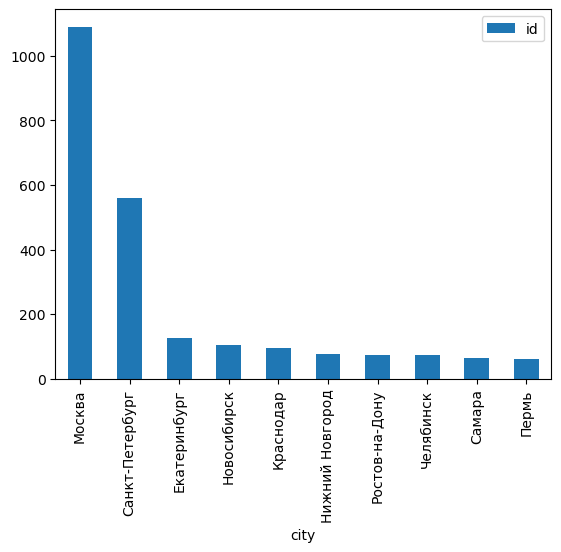

In [125]:
artists_followers.groupby('city')['id'].nunique().to_frame().sort_values(by='id', ascending=False).head(10).plot(kind = 'bar')

Разпределение пола подписчиков

<Axes: ylabel='count'>

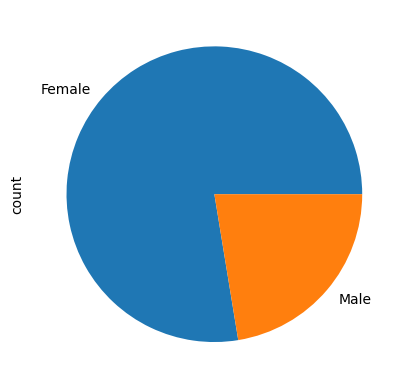

In [120]:
artists_followers['sex'].value_counts().plot(kind = 'pie')

Топ 10 университетов по количеству учащихся в них подписчиков

<Axes: xlabel='university_name'>

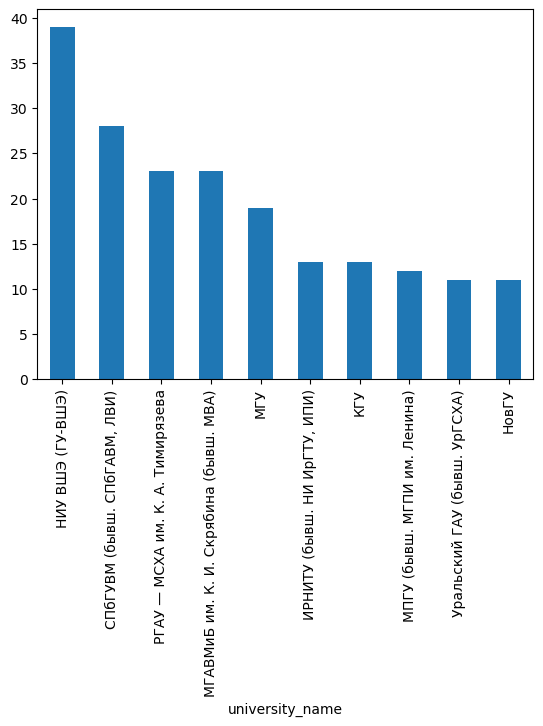

In [127]:
artists_followers['university_name'].value_counts().head(10).plot(kind = 'bar')

График годов выпуска подписчиков

<Axes: xlabel='graduation'>

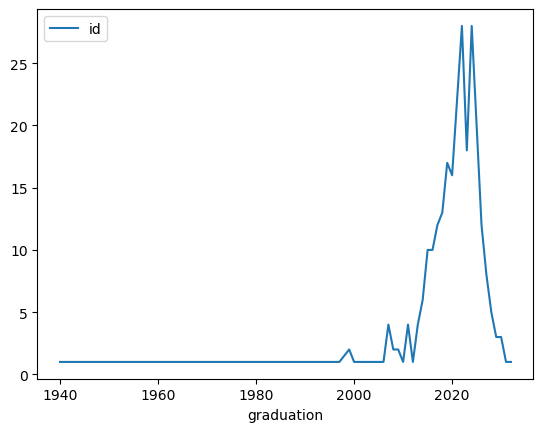

In [176]:
artists_followers[artists_followers['graduation']!=0.0].groupby('graduation')['id'].nunique().to_frame().plot()

Распределение возраста подписчиков

<Axes: ylabel='Frequency'>

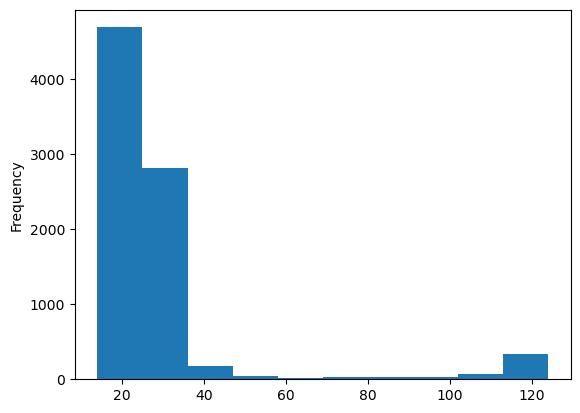

In [196]:
artists_followers[artists_followers['age']!='unknown']['age'].plot(kind='hist')